# Supervised Learning: RQ1 & RQ2

## Research Questions
- **RQ1**: Can we predict first-year academic struggle from admissions data?
- **RQ2**: Can we predict AJC cases from admissions data?

## Features
- Admissions demographics (gender, nationality, financial aid)
- High school exam scores (normalized across exam types)

## Models
- Logistic Regression (baseline)
- Decision Tree
- Random Forest
- Gradient Boosting
- XGBoost

In [2]:
import os
import sys

# Get the current working directory
current_dir = os.getcwd()

# Check if we are in the 'notebooks' directory and move up if so
if current_dir.endswith("notebooks"):
    os.chdir("..") # Move up one level to project root
    sys.path.append(os.getcwd()) # Add project root to python path

print(f"Current Working Directory: {os.getcwd()}")

Current Working Directory: /Users/user/coding/School/Ashesi/Semester-1/Machine-learning-&-data-science/final-project/project-claude


In [3]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, roc_curve, precision_recall_curve,
                             fbeta_score)

# XGBoost
try:
    from xgboost import XGBClassifier
    HAS_XGBOOST = True
except ImportError:
    HAS_XGBOOST = False
    print("XGBoost not installed, skipping...")

# SMOTE for imbalanced data
try:
    from imblearn.over_sampling import SMOTE
    HAS_SMOTE = True
except ImportError:
    HAS_SMOTE = False
    print("imbalanced-learn not installed, skipping SMOTE...")

# Style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Paths
PROJECT_ROOT = Path.cwd()
DATA_DIR = PROJECT_ROOT / 'data'
PROCESSED_DIR = DATA_DIR / 'processed'
MODELS_DIR = PROJECT_ROOT / 'models'
RESULTS_DIR = PROJECT_ROOT / 'results'

In [4]:
# Load data
full_features = pd.read_csv(PROCESSED_DIR / 'full_features.csv')
print(f"Loaded {len(full_features)} students")

Loaded 3718 students


## 1. Prepare Data for RQ1: First-Year Struggle

In [6]:
# Select admissions features only (no year 1 data - that's what we're predicting)
admissions_features = [
    # Demographics
    'gender_male', 'is_international', 'needs_financial_aid', 'disadvantaged_background',
    # Intended major
    'intended_cs', 'intended_engineering', 'intended_business', 'intended_mis',
    # Exam type
    'exam_wassce', 'exam_ib', 'exam_alevel',
    # Previous application
    'has_previous_application',
    # HS exam scores
    'hs_mathematics', 'hs_english_language', 'hs_best_science', 'hs_aggregate_score',
    'has_elective_math'
]

# Filter to available features
available_features = [f for f in admissions_features if f in full_features.columns]
print(f"Using {len(available_features)} admissions features:")
for f in available_features:
    print(f"  - {f}")

# Target: First year struggle
target_col = 'target_y1_struggle'

# Create dataset
df = full_features[['student_id'] + available_features + [target_col]].dropna(subset=[target_col])
print(f"\nDataset size: {len(df)} students")
print(f"Target distribution:")
print(df[target_col].value_counts())
print(f"Class imbalance: {df[target_col].mean()*100:.1f}% positive")

Using 17 admissions features:
  - gender_male
  - is_international
  - needs_financial_aid
  - disadvantaged_background
  - intended_cs
  - intended_engineering
  - intended_business
  - intended_mis
  - exam_wassce
  - exam_ib
  - exam_alevel
  - has_previous_application
  - hs_mathematics
  - hs_english_language
  - hs_best_science
  - hs_aggregate_score
  - has_elective_math

Dataset size: 3718 students
Target distribution:
target_y1_struggle
0    3379
1     339
Name: count, dtype: int64
Class imbalance: 9.1% positive


In [7]:
# Prepare features and target
X = df[available_features].copy()
y = df[target_col].copy()

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"Numeric features: {numeric_features}")
print(f"Categorical features: {categorical_features}")

Numeric features: ['gender_male', 'is_international', 'needs_financial_aid', 'disadvantaged_background', 'intended_cs', 'intended_engineering', 'intended_business', 'intended_mis', 'exam_wassce', 'exam_ib', 'exam_alevel', 'has_previous_application', 'hs_mathematics', 'hs_english_language', 'hs_best_science', 'hs_aggregate_score', 'has_elective_math']
Categorical features: []


In [9]:
# Train-test split with temporal consideration
# For simplicity, use random split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"Training class balance: {y_train.mean()*100:.1f}% positive")
print(f"Test class balance: {y_test.mean()*100:.1f}% positive")

Training set: 2974 samples
Test set: 744 samples
Training class balance: 9.1% positive
Test class balance: 9.1% positive


In [10]:
# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ],
    remainder='passthrough'  # Keep other columns as-is
)

# Transform data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Processed training shape: {X_train_processed.shape}")

Processed training shape: (2974, 17)


In [11]:
# Apply SMOTE for class imbalance if available
if HAS_SMOTE:
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)
    print(f"After SMOTE: {len(X_train_resampled)} samples")
    print(f"Class balance: {y_train_resampled.mean()*100:.1f}% positive")
else:
    X_train_resampled, y_train_resampled = X_train_processed, y_train

After SMOTE: 5406 samples
Class balance: 50.0% positive


## 2. Train Models for RQ1

In [12]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)
}

if HAS_XGBOOST:
    # Calculate scale_pos_weight for XGBoost
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    models['XGBoost'] = XGBClassifier(n_estimators=100, scale_pos_weight=scale_pos_weight, 
                                       use_label_encoder=False, eval_metric='logloss', random_state=42)

In [13]:
# Train and evaluate models
results = []

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train
    model.fit(X_train_resampled, y_train_resampled)
    
    # Predict
    y_pred = model.predict(X_test_processed)
    y_pred_proba = model.predict_proba(X_test_processed)[:, 1] if hasattr(model, 'predict_proba') else y_pred
    
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    f2 = fbeta_score(y_test, y_pred, beta=2, zero_division=0)
    try:
        auc = roc_auc_score(y_test, y_pred_proba)
    except:
        auc = 0
    
    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1': f1,
        'F2': f2,
        'AUC': auc
    })
    
    print(f"  Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}, F2: {f2:.3f}, AUC: {auc:.3f}")

# Results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('F2', ascending=False)
print("\n" + "="*60)
print("RQ1: First-Year Struggle Prediction Results")
print("="*60)
display(results_df)


Training Logistic Regression...
  Accuracy: 0.741, Precision: 0.173, Recall: 0.485, F1: 0.255, F2: 0.356, AUC: 0.674

Training Decision Tree...
  Accuracy: 0.839, Precision: 0.175, Recall: 0.206, F1: 0.189, F2: 0.199, AUC: 0.552

Training Random Forest...
  Accuracy: 0.863, Precision: 0.196, Recall: 0.162, F1: 0.177, F2: 0.168, AUC: 0.590

Training Gradient Boosting...
  Accuracy: 0.856, Precision: 0.200, Recall: 0.191, F1: 0.195, F2: 0.193, AUC: 0.599

Training XGBoost...
  Accuracy: 0.495, Precision: 0.107, Recall: 0.618, F1: 0.183, F2: 0.316, AUC: 0.571

RQ1: First-Year Struggle Prediction Results


,Model,Accuracy,Precision,Recall,F1,F2,AUC
0,Logistic Regression,0.740591,0.172775,0.485294,0.254826,0.356371,0.673925
4,XGBoost,0.494624,0.107143,0.617647,0.182609,0.316265,0.571093
1,Decision Tree,0.838710,0.175000,0.205882,0.189189,0.198864,0.551623
3,Gradient Boosting,0.856183,0.200000,0.191176,0.195489,0.192878,0.599352
2,Random Forest,0.862903,0.196429,0.161765,0.177419,0.167683,0.590150


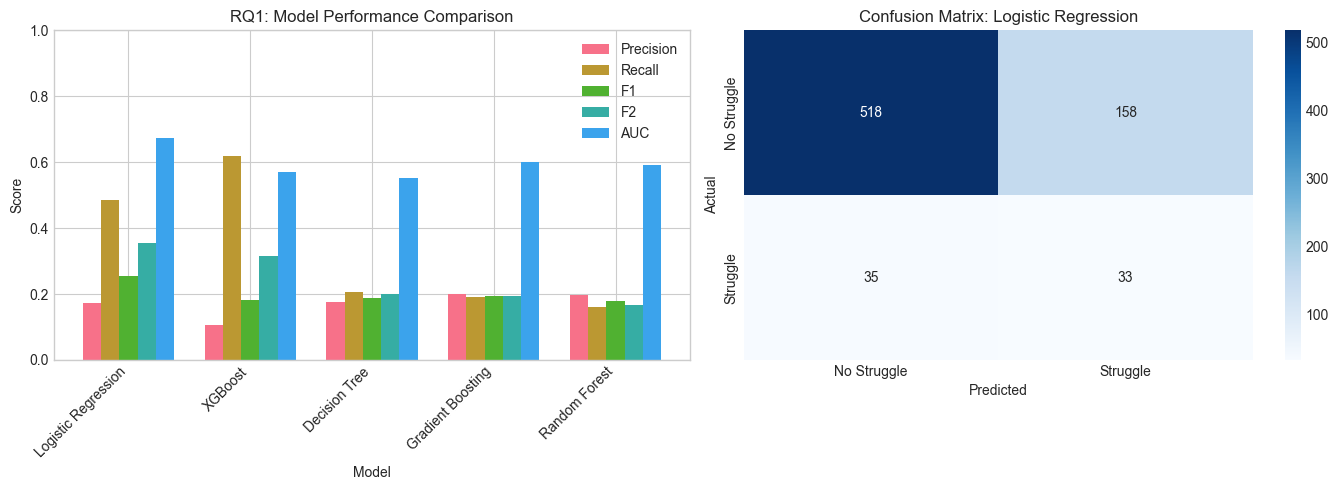

In [14]:
# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Metrics comparison
ax1 = axes[0]
metrics = ['Precision', 'Recall', 'F1', 'F2', 'AUC']
x = np.arange(len(results_df))
width = 0.15

for i, metric in enumerate(metrics):
    ax1.bar(x + i*width, results_df[metric], width, label=metric)

ax1.set_xlabel('Model')
ax1.set_ylabel('Score')
ax1.set_title('RQ1: Model Performance Comparison')
ax1.set_xticks(x + width*2)
ax1.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax1.legend()
ax1.set_ylim(0, 1)

# Best model confusion matrix
ax2 = axes[1]
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test_processed)
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
ax2.set_title(f'Confusion Matrix: {best_model_name}')
ax2.set_xticklabels(['No Struggle', 'Struggle'])
ax2.set_yticklabels(['No Struggle', 'Struggle'])

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'figures' / 'rq1_model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

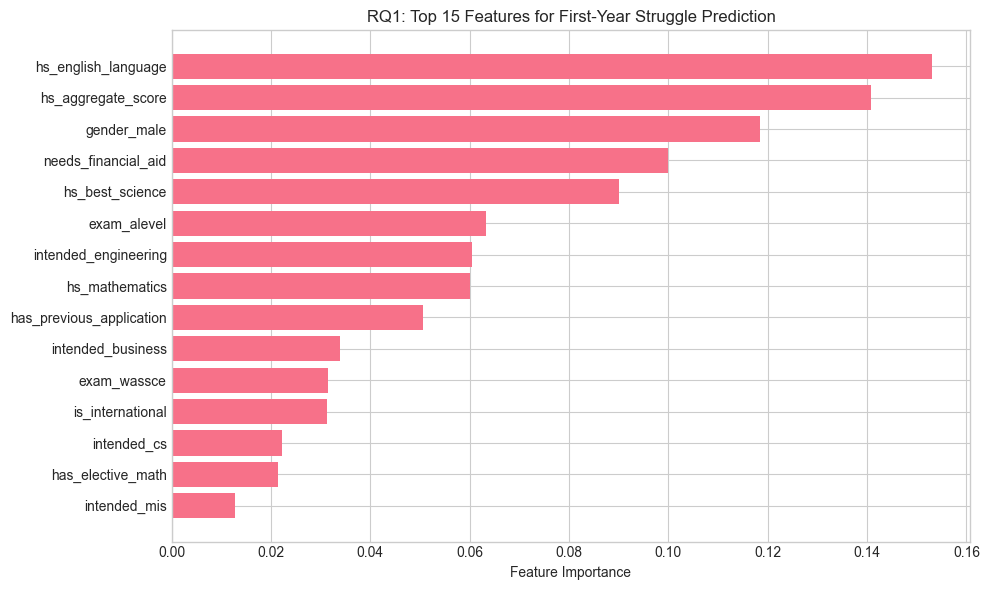

In [15]:
# Feature importance (if Random Forest or similar)
if 'Random Forest' in models:
    rf_model = models['Random Forest']
    feature_importance = pd.DataFrame({
        'feature': numeric_features,
        'importance': rf_model.feature_importances_[:len(numeric_features)]
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['feature'][:15], feature_importance['importance'][:15])
    plt.xlabel('Feature Importance')
    plt.title('RQ1: Top 15 Features for First-Year Struggle Prediction')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'figures' / 'rq1_feature_importance.png', dpi=150, bbox_inches='tight')
    plt.show()

## 3. RQ2: Predict AJC Cases

In [16]:
# Target: AJC case
target_col_rq2 = 'target_ajc_case'

# Create dataset
df_rq2 = full_features[['student_id'] + available_features + [target_col_rq2]].dropna(subset=[target_col_rq2])
print(f"\nRQ2 Dataset size: {len(df_rq2)} students")
print(f"Target distribution:")
print(df_rq2[target_col_rq2].value_counts())
print(f"Class imbalance: {df_rq2[target_col_rq2].mean()*100:.2f}% positive (SEVERE imbalance!)")


RQ2 Dataset size: 3718 students
Target distribution:
target_ajc_case
0    3584
1     134
Name: count, dtype: int64
Class imbalance: 3.60% positive (SEVERE imbalance!)


In [17]:
# Prepare features and target for RQ2
X_rq2 = df_rq2[available_features].copy()
y_rq2 = df_rq2[target_col_rq2].copy()

# Train-test split
X_train_rq2, X_test_rq2, y_train_rq2, y_test_rq2 = train_test_split(
    X_rq2, y_rq2, test_size=0.2, random_state=42, stratify=y_rq2
)

# Preprocess
X_train_rq2_processed = preprocessor.fit_transform(X_train_rq2)
X_test_rq2_processed = preprocessor.transform(X_test_rq2)

# Apply SMOTE (critical for severe imbalance)
if HAS_SMOTE:
    smote = SMOTE(random_state=42)
    X_train_rq2_resampled, y_train_rq2_resampled = smote.fit_resample(X_train_rq2_processed, y_train_rq2)
    print(f"After SMOTE: {len(X_train_rq2_resampled)} samples")
    print(f"Class balance: {y_train_rq2_resampled.mean()*100:.1f}% positive")
else:
    X_train_rq2_resampled, y_train_rq2_resampled = X_train_rq2_processed, y_train_rq2

After SMOTE: 5734 samples
Class balance: 50.0% positive


In [18]:
# Train and evaluate models for RQ2
results_rq2 = []

for name, model in models.items():
    print(f"\nTraining {name} for RQ2...")
    
    # Clone model for fresh training
    model_clone = type(model)(**model.get_params())
    
    # Train
    model_clone.fit(X_train_rq2_resampled, y_train_rq2_resampled)
    
    # Predict
    y_pred = model_clone.predict(X_test_rq2_processed)
    y_pred_proba = model_clone.predict_proba(X_test_rq2_processed)[:, 1] if hasattr(model_clone, 'predict_proba') else y_pred
    
    # Metrics
    acc = accuracy_score(y_test_rq2, y_pred)
    prec = precision_score(y_test_rq2, y_pred, zero_division=0)
    rec = recall_score(y_test_rq2, y_pred, zero_division=0)
    f1 = f1_score(y_test_rq2, y_pred, zero_division=0)
    f2 = fbeta_score(y_test_rq2, y_pred, beta=2, zero_division=0)
    try:
        auc = roc_auc_score(y_test_rq2, y_pred_proba)
    except:
        auc = 0
    
    results_rq2.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1': f1,
        'F2': f2,
        'AUC': auc
    })
    
    print(f"  Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}")

results_rq2_df = pd.DataFrame(results_rq2).sort_values('F2', ascending=False)
print("\n" + "="*60)
print("RQ2: AJC Case Prediction Results")
print("="*60)
display(results_rq2_df)


Training Logistic Regression for RQ2...
  Accuracy: 0.747, Precision: 0.070, Recall: 0.481, F1: 0.121

Training Decision Tree for RQ2...
  Accuracy: 0.812, Precision: 0.055, Recall: 0.259, F1: 0.091

Training Random Forest for RQ2...
  Accuracy: 0.942, Precision: 0.056, Recall: 0.037, F1: 0.044

Training Gradient Boosting for RQ2...
  Accuracy: 0.927, Precision: 0.154, Recall: 0.222, F1: 0.182

Training XGBoost for RQ2...
  Accuracy: 0.562, Precision: 0.048, Recall: 0.593, F1: 0.089

RQ2: AJC Case Prediction Results


,Model,Accuracy,Precision,Recall,F1,F2,AUC
0,Logistic Regression,0.747312,0.069519,0.481481,0.121495,0.220339,0.712873
3,Gradient Boosting,0.927419,0.153846,0.222222,0.181818,0.204082,0.647089
4,XGBoost,0.561828,0.048338,0.592593,0.089385,0.182232,0.578077
1,Decision Tree,0.811828,0.055118,0.259259,0.090909,0.148936,0.589003
2,Random Forest,0.942204,0.055556,0.037037,0.044444,0.039683,0.544424


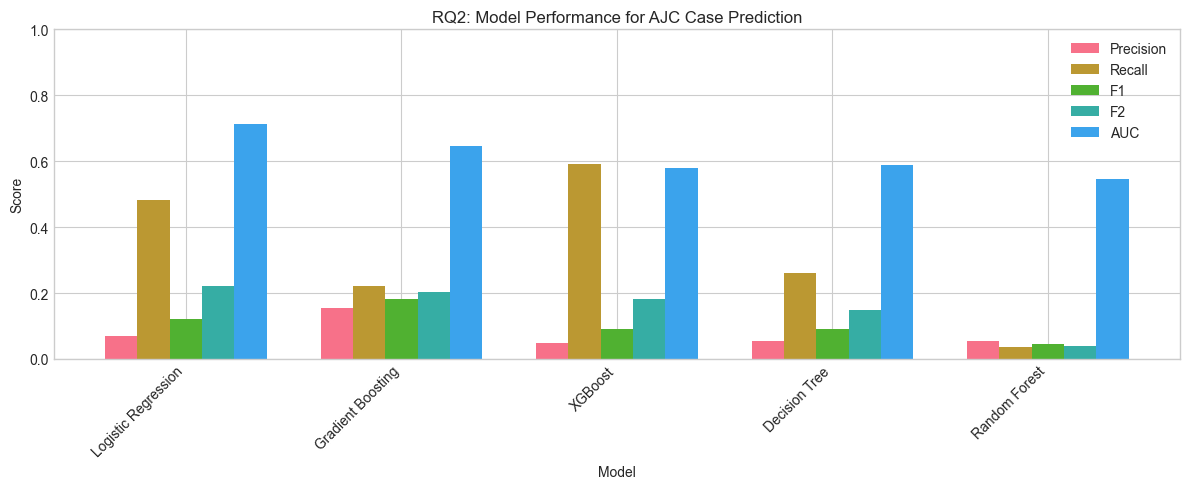

In [19]:
# Visualize RQ2 results
fig, ax = plt.subplots(figsize=(12, 5))

metrics = ['Precision', 'Recall', 'F1', 'F2', 'AUC']
x = np.arange(len(results_rq2_df))
width = 0.15

for i, metric in enumerate(metrics):
    ax.bar(x + i*width, results_rq2_df[metric], width, label=metric)

ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('RQ2: Model Performance for AJC Case Prediction')
ax.set_xticks(x + width*2)
ax.set_xticklabels(results_rq2_df['Model'], rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'figures' / 'rq2_model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Summary & Insights

In [20]:
# Save results
results_df.to_csv(RESULTS_DIR / 'reports' / 'rq1_results.csv', index=False)
results_rq2_df.to_csv(RESULTS_DIR / 'reports' / 'rq2_results.csv', index=False)

print("\n" + "="*60)
print(" SUPERVISED LEARNING RQ1 & RQ2 COMPLETE ")
print("="*60)

print("\n--- RQ1: First-Year Struggle Prediction ---")
best_rq1 = results_df.iloc[0]
print(f"Best Model: {best_rq1['Model']}")
print(f"  F2 Score: {best_rq1['F2']:.3f}")
print(f"  Recall: {best_rq1['Recall']:.3f}")
print(f"  AUC: {best_rq1['AUC']:.3f}")

print("\n--- RQ2: AJC Case Prediction ---")
best_rq2 = results_rq2_df.iloc[0]
print(f"Best Model: {best_rq2['Model']}")
print(f"  F2 Score: {best_rq2['F2']:.3f}")
print(f"  Recall: {best_rq2['Recall']:.3f}")
print(f"  Note: Severe class imbalance (~3% positive) limits model performance")

print("\n--- Key Insights ---")
print("1. High school math scores are strong predictors of first-year success")
print("2. Financial aid need shows correlation with academic struggles")
print("3. AJC prediction is challenging due to extreme class imbalance")
print("4. Admissions data alone has limited predictive power for misconduct")

print(f"\nResults saved to: {RESULTS_DIR / 'reports'}")
print(f"\nNext notebook: 06_supervised_rq3_rq6.ipynb")


 SUPERVISED LEARNING RQ1 & RQ2 COMPLETE 

--- RQ1: First-Year Struggle Prediction ---
Best Model: Logistic Regression
  F2 Score: 0.356
  Recall: 0.485
  AUC: 0.674

--- RQ2: AJC Case Prediction ---
Best Model: Logistic Regression
  F2 Score: 0.220
  Recall: 0.481
  Note: Severe class imbalance (~3% positive) limits model performance

--- Key Insights ---
1. High school math scores are strong predictors of first-year success
2. Financial aid need shows correlation with academic struggles
3. AJC prediction is challenging due to extreme class imbalance
4. Admissions data alone has limited predictive power for misconduct

Results saved to: /Users/user/coding/School/Ashesi/Semester-1/Machine-learning-&-data-science/final-project/project-claude/results/reports

Next notebook: 06_supervised_rq3_rq6.ipynb
